![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [6]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

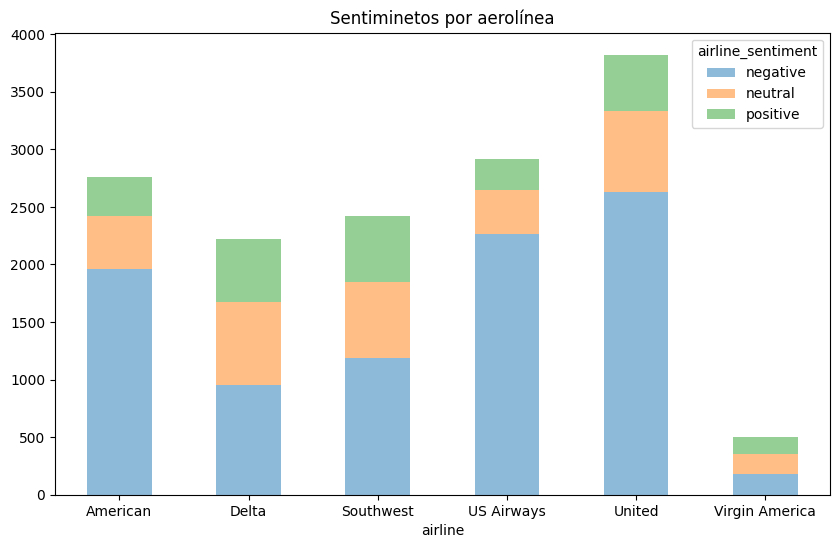

In [8]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import re
import unidecode
import emoji

In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [12]:
# Se eliminan los enlaces, menciones (@) y hashtags (#). También se ajustan los espacios en el texto y los emojis se pasan a texto para usarlos en el análisis.
def limpiar_texto(txt):
    res = re.sub(r'http\S+', '', txt)
    res = re.sub(r'@\w+', '', res)
    res = re.sub(r'#\w+', '', res)
    res = unidecode.unidecode(res)
    res = re.sub(r'\s+', ' ', res).strip()
    res = emoji.demojize(res, delimiters=("", " "))
    return res

X_train_p1 = X_train.apply(limpiar_texto)

In [13]:
# Se realiza una busqueda aleatoria de los parámetros del random forest con los datos ajustados y también del parámetro de n gramas del CountVectorizer
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('clf', RandomForestClassifier(random_state=42))
])
params = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'clf__n_estimators': np.arange(100, 1001, 100),
    'clf__max_depth': [None] + list(np.arange(5, 51, 5)),
    'clf__min_samples_split': np.arange(2, 11, 2)
}
random_search_p1 = RandomizedSearchCV(
    pipeline,
    params,
    n_iter=40,
    cv=3,
    scoring=make_scorer(accuracy_score), 
    random_state=42,
    verbose=2 
)
random_search_p1.fit(X_train_p1, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  13.8s
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  12.0s
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  17.1s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=   9.1s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=   9.9s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=   9.3s
[CV] END clf__max_depth=40, clf__min_samples_split=10, clf__n_estimators=100, vect__ngram_range=(1, 2); total time=   2.5s
[CV] END clf__max_depth=40, clf__min_samples_split=10, clf__n_estimators=100, vect_

KeyboardInterrupt: 

In [36]:
print("Mejor Accuracy en train: %s" % random_search_p1.best_score_)
print("Mejores Parámetros: %s" % random_search_p1.best_params_)

Mejor Accuracy en train: 0.7299133521615496
Mejores Parámetros: {'vect__ngram_range': (1, 2), 'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__max_depth': None}


In [13]:
vect_p1 = CountVectorizer(lowercase=False,ngram_range=(1, 2))
X_train_p1 = vect_p1.fit_transform(X_train)
rf_p1 = RandomForestClassifier(n_estimators=800,min_samples_split=2,max_depth=None,random_state=42)
rf_p1.fit(X_train_p1, y_train)

RandomForestClassifier(n_estimators=800, random_state=42)

In [14]:
X_test_p1 = X_test.apply(limpiar_texto)

In [15]:
X_test_p1 = vect_p1.transform(X_test)
y_pred_p1 = rf_p1.predict(X_test_p1)
accuracy_p1 = accuracy_score(y_test, y_pred_p1)
accuracy_p1

0.7584850993377483

En principio se quitaron enlaces, menciones y hashtags de los textos de cada tweet, además de una limpieza de caracteres y extracción de texto de los emojis en éstos. Posteriormente se realizó una busqueda aleatoria de parámetros (40 iteraciones y 3 folds para la validación cruzada de cada uno) cuyo resultado fue el siguiente: n_estimators=800, min_samples_split=2, max_depth=None (para el Random Forest) y ngram_range=(1, 2) (para el CountVectorizer). Se entrenó un modelo con los parámetros encontrados y finalmente se realizó una predicción con la muestra de test (luego de aplicar la misma limpieza) con un resultado de Accuracy de 75.84%, lo que indica que el modelo fue capaz de clasificar correctamente tres cuartas partes del conjunto de prueba.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 2


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [27]:
# Celda 3

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

X_train_p3 = X_train.apply(limpiar_texto)
X_test_p3 = X_test.apply(limpiar_texto)


In [28]:
def split_into_lemmas(text):
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

vect_lemas = CountVectorizer(analyzer=split_into_lemmas)

In [29]:
X_dtm_3_train = vect_lemas.fit_transform(X_train_p3)

In [30]:
params = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 51, 5)),
    'min_samples_split': np.arange(2, 11, 2)
}
random_search_p3 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    n_iter=40,
    cv=3,
    scoring=make_scorer(accuracy_score), 
    random_state=42,
    verbose=2 
)
random_search_p3.fit(X_dtm_3_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=   6.9s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=   6.8s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=   6.8s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   4.1s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   4.1s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   4.1s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   3.2s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   3.2s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=   8.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=   8.0s
[CV] END max_depth=10, min_samples_split=2

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30, 35, 40, 45, 50],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=42, scoring=make_scorer(accuracy_score),
                   verbose=2)

In [32]:
print("Mejor Accuracy en train: %s" % random_search_p3.best_score_)
print("Mejores Parámetros: %s" % random_search_p3.best_params_)

Mejor Accuracy en train: 0.7265488141310783
Mejores Parámetros: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': None}


In [33]:
rf_p3 = RandomForestClassifier(n_estimators=700,min_samples_split=2,max_depth=None,random_state=42)
rf_p3.fit(X_dtm_3_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=42)

In [34]:
X_test_p3 = vect_lemas.transform(X_test_p3)
y_pred_p3 = rf_p3.predict(X_test_p3)
accuracy_p3 = accuracy_score(y_test, y_pred_p3)
accuracy_p3

0.7531043046357616

Se inicia aplicando la función limpiar_texto a las muestras X de entrenamiento y prueba. Adicionalmente, se crea la función split_into_lemmas, que se encarga de tomar los textos, dividirlos y aplicarles la lematización. Luego se hace una búsqueda de hiperparámetros para el modelo de Random Forest: 'n_estimators': 700, 'min_samples_split': 2. Luego se entrena el modelo con los datos de entrenamiento lematizados, posteriormente se obtienen resultados utilizando los datos de prueba lematizados, obteniendo un acurrancy de 0.7531.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 4


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 5
